In [ ]:
# Import Pandas, Numpy, Seaborn, Matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Import Label Encoder and train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn as sklearn
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

import pickle
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# load dataset
from google.colab import files
# uploaded = files.upload()

df = pd.read_csv('./insurance.csv')
df.head()

## Atacan

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [ ]:
def load_dataset(filename, extension='.csv'):
    """
    Iports the dataset
    Parameters
    ----------
    dataset

    Returns
    -------
    dataframe
    """
    if 'csv' in extension:
        data = pd.read_csv(filename+extension)
    elif 'xls' in extension:
        data = pd.read_excel(filename+extension)
    elif 'pkl' in extension:
        data = pd.DataFrame(pickle.load(open(filename+extension, 'rb')))
    return data
# df = load_dataset("insurance")

In [ ]:
######################################################
# Exploratory Data Analysis
######################################################

# Tablonun özet istatistikleri:
def check_df(dataframe, head=5):
    """
    Prints out the shape, types, head, missing values and quantiles of the dataframe
    Parameters
    ----------
    dataframe
    head

    Returns
    -------
    No return
    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("################ Missing Values ################")
    print(dataframe.isnull().sum())
check_df(df, 5)
df.describe()

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

,age,bmi,children,charges
count,1338.000,1338.000,1338.000,1338.000
mean,39.207,30.663,1.095,13270.422
std,14.050,6.098,1.205,12110.011
min,18.000,15.960,0.000,1121.874
25%,27.000,26.296,0.000,4740.287
50%,39.000,30.400,1.000,9382.033
75%,51.000,34.694,2.000,16639.913
max,64.000,53.130,5.000,63770.428


In [ ]:
# Kategorik ve sayısal değişkenlerin belirlenmesi
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Determines the categorical, numerical and categorical but cardinal columns.

    Parameters
    ------
        dataframe: dataframe
                dataframe whihc inludes the columns
        cat_th: int, optional
                class threshold valuse for determining numeric but categorical variable
        car_th: int, optional
                class threshold valuse for determining categoric but cardinal variable

    Returns
    ------
        cat_cols: list
                categorical columns
        num_cols: list
                numerical columns
        cat_but_car: list
                categoric but cardinal columns

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total columns
        cat_cols = all_cat_cols + num_but_cat - cat_but_car
        num_cols = all_num_cols - num_but_cat
    """

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")

    # cat cols
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    print(f'init cat_cols: {len(cat_cols)}')

    # num cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    print(f'init num_cols: {len(num_cols)}')

    # num but cat cols
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat but car cols
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    print(f'cat_but_car: {len(cat_but_car)}')

    # cat cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    print(f'final cat_cols: {len(cat_cols)}')

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f'final num_cols: {len(num_cols)}')

    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
init cat_cols: 3
init num_cols: 4
num_but_cat: 1
cat_but_car: 0
final cat_cols: 4
final num_cols: 3


In [ ]:
######################################################
# Feature Engineering
######################################################
def new_feature_interval(dataframe, col, interval_value, header="new"):
    if header == "new":
        new_col = "new_" + col
    else:
        new_col = header
    for intrvl, val in interval_value.items():
        dataframe.loc[[var in intrvl for var in dataframe[col]], new_col] = val
new_feature_interval(df, 'age',
                   {
                    pd.Interval(-np.inf, 18, closed='neither'):'young',
                    pd.Interval(18, 44, closed='left'):'mature',
                    pd.Interval(44, 64, closed='left'):'senior',
                    pd.Interval(64, np.inf, closed='left'):'old'
                   }
                   )

# Tablonun özet istatistikleri:
check_df(df)

##################### Shape #####################
(1338, 8)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
new_age      object
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges new_age
0   19  female 27.900         0    yes  southwest 16884.924  mature
1   18    male 33.770         1     no  southeast  1725.552  mature
2   28    male 33.000         3     no  southeast  4449.462  mature
3   33    male 22.705         0     no  northwest 21984.471  mature
4   32    male 28.880         0     no  northwest  3866.855  mature
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges new_age
1333   50    male 30.970         3     no  northwest 10600.548  senior
1334   18  female 31.920         0     no  northeast  2205.981  matu

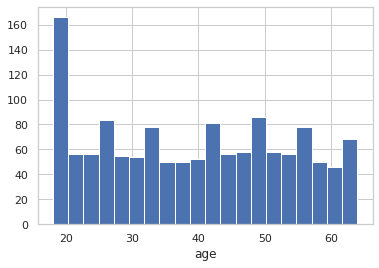

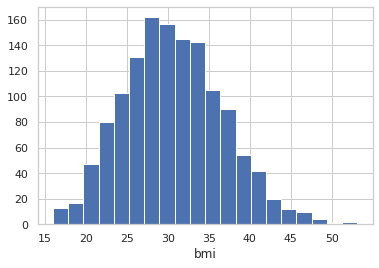

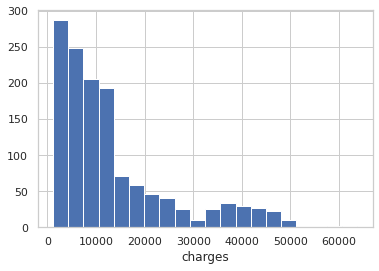

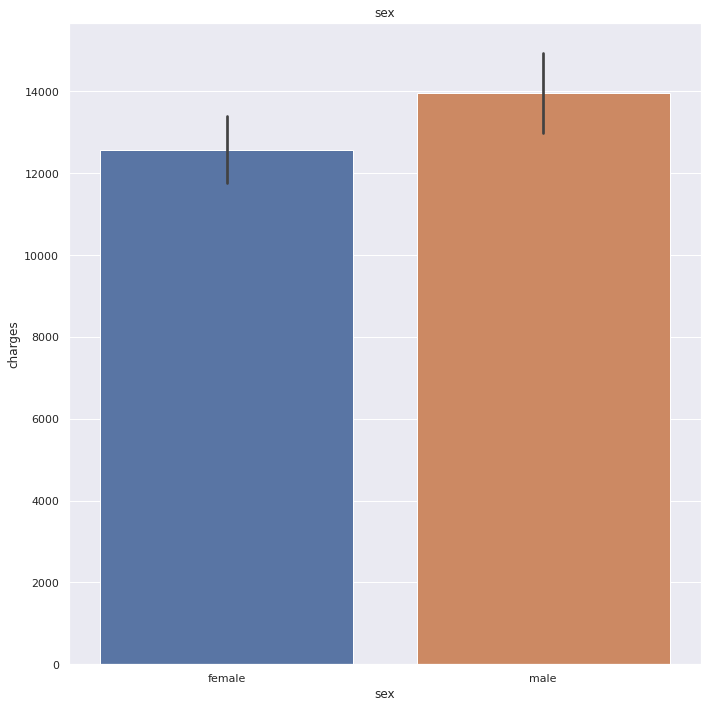

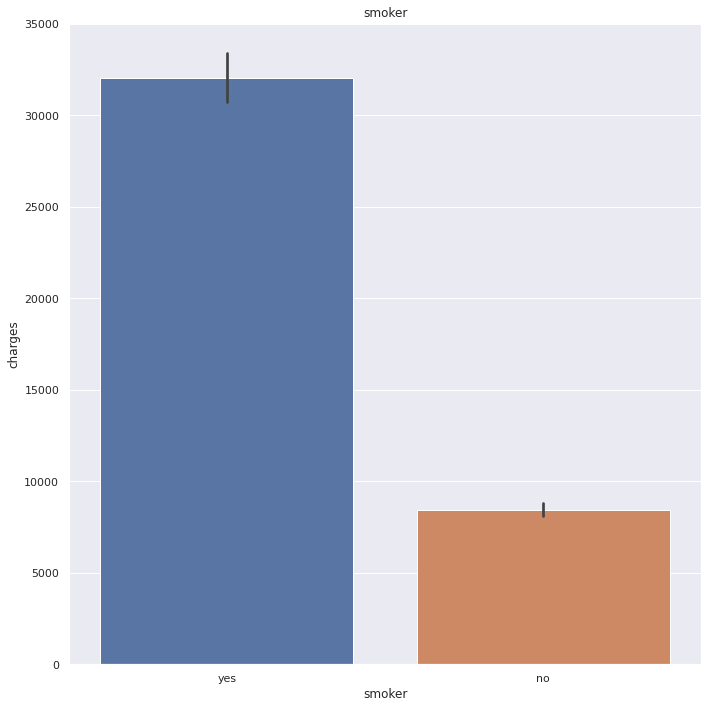

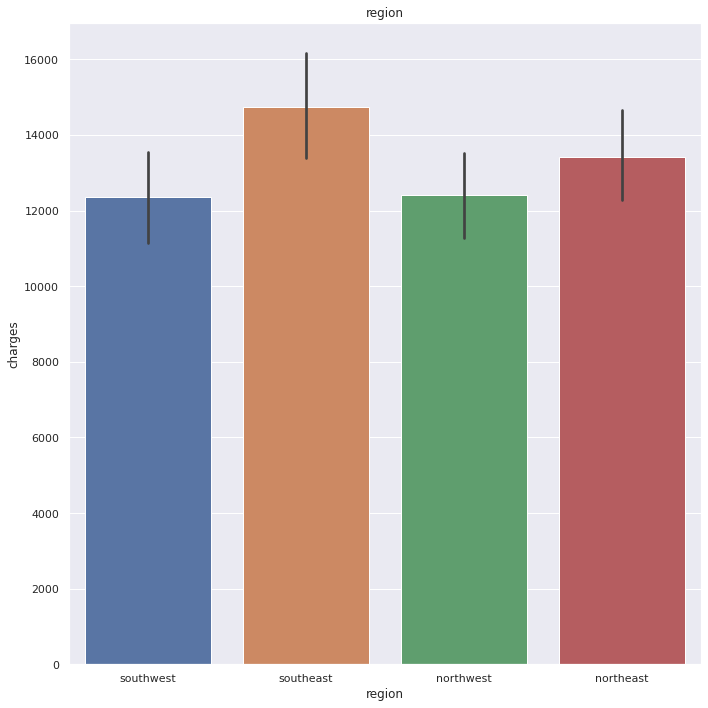

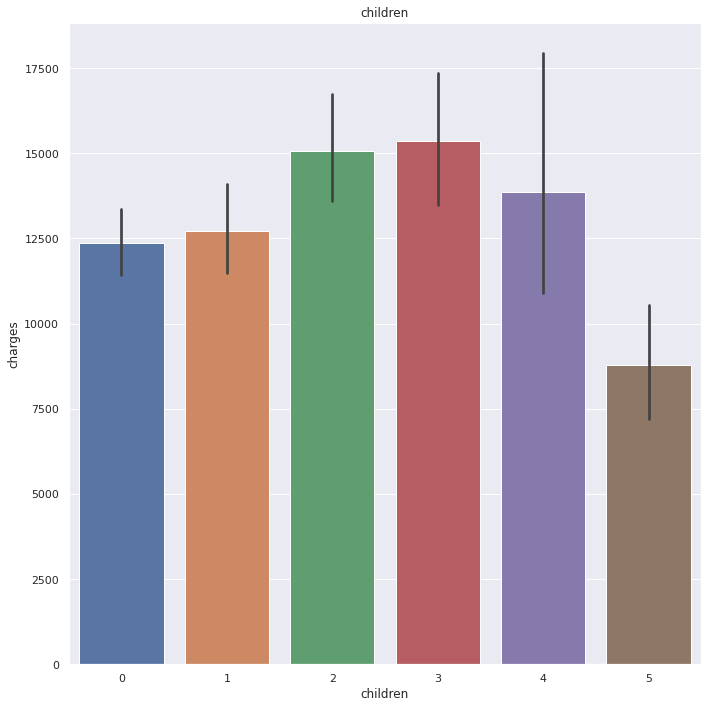

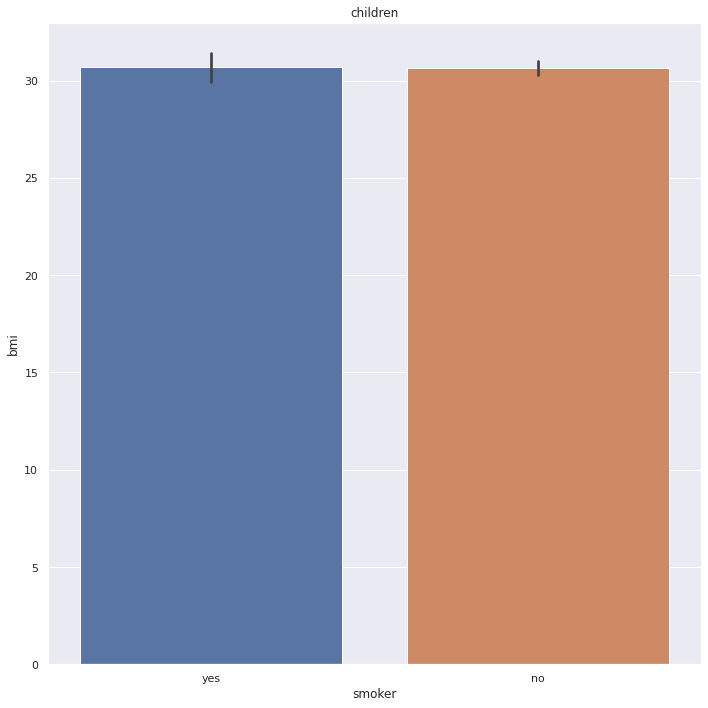

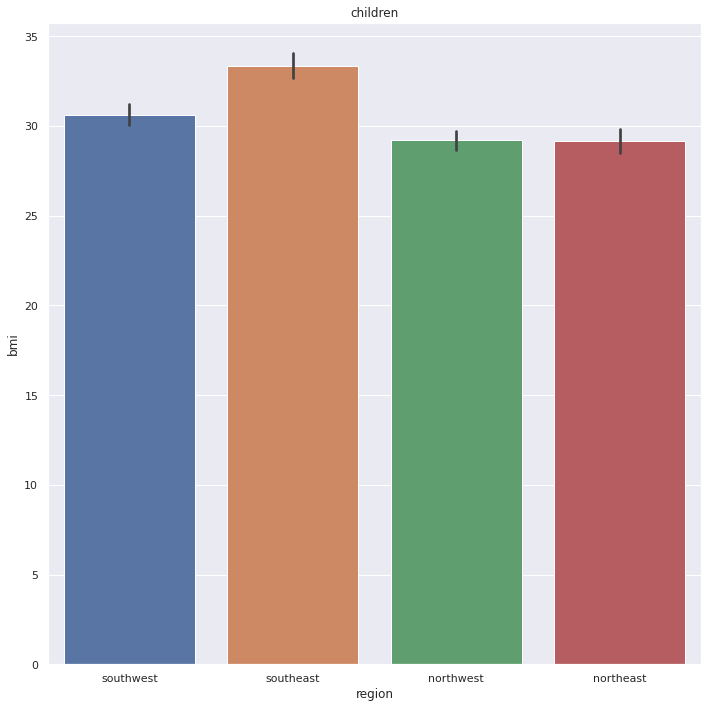

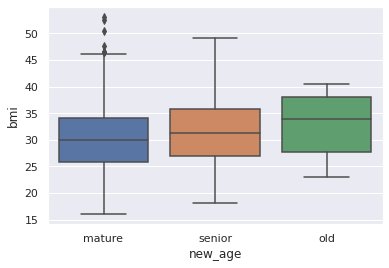

In [ ]:
##########################
# Görsel Analiz
##########################
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show()
for col in num_cols:
    plot_numerical_col(df, col)

def plot_bar(df, x, y, title, save=None):
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x=x, y=y, data=df)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    if save != None:
        plt.savefig(save)

for col in cat_cols:
    plot_bar(df, col, 'charges', col)

plot_bar(df, 'smoker', 'bmi', col)
plot_bar(df, 'region', 'bmi', col)
sns.boxplot(x='new_age',y='bmi',data=df)

In [ ]:
##########################
# Target Analizi
##########################

# Tüm kategorik değişkenlerin özet istatistikleri:
def cat_cols_summary(dataframe, cat_cols, plot=False):
    """
    Ratio of the categorical classes in a column
    Parameters
    ----------
    dataframe
    col_name
    plot

    Returns
    -------
    No return
    """
    print("############## Frequency and Ratio #############")
    print(pd.DataFrame({"Freq": dataframe[cat_cols].value_counts(),
                        "Ratio": 100 * dataframe[cat_cols].value_counts() / len(dataframe)}).rename_axis(cat_cols))

    if plot:
        for col in cat_cols:
            sns.countplot(x=dataframe[col], data=dataframe)
            plt.show()
cat_cols_summary(df, 'charges')

############## Frequency and Ratio #############
           Freq  Ratio
charges               
1639.563      2  0.149
16884.924     1  0.075
29330.983     1  0.075
2221.564      1  0.075
19798.055     1  0.075
...         ...    ...
7345.084      1  0.075
26109.329     1  0.075
28287.898     1  0.075
1149.396      1  0.075
29141.360     1  0.075

[1337 rows x 2 columns]


In [ ]:
##########################
# Feature Analizi
##########################

# Tüm sayısal değişkenlerin özet istatistikleri:
def num_cols_summary(dataframe, num_cols, plot=False):
    """
    Numerical variable exploration
    Parameters
    ----------
    dataframe
    numerical_col
    plot

    Returns
    -------
    No return
    """
    print("################### Describe ###################")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40,
                 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[num_cols].describe(quantiles).T)

    if plot:
        for col in num_cols:
            dataframe[col].hist(bins=20)
            plt.xlabel(col)
            plt.title(col)
            plt.show()
num_cols_summary(df, num_cols, False)

################### Describe ###################
           count      mean       std      min       5%      10%      20%      30%      40%      50%       60%       70%       80%       90%       95%       99%  \
age     1338.000    39.207    14.050   18.000   18.000   19.000   24.000   29.000   34.000   39.000    44.000    49.000    54.000    59.000    62.000    64.000   
bmi     1338.000    30.663     6.098   15.960   21.256   22.990   25.326   27.360   28.797   30.400    32.032    33.660    35.860    38.619    41.106    46.408   
charges 1338.000 13270.422 12110.011 1121.874 1757.753 2346.534 3991.576 5484.847 7369.053 9382.033 11399.857 13767.875 20260.626 34831.720 41181.828 48537.481   

              max  
age        64.000  
bmi        53.130  
charges 63770.428  


In [ ]:
##########################
# Target vs Features Analizi
##########################

def target_vs_num_cols_summary(dataframe, target, num_col):
    """
    Prints out the defined numeric variable mean of the target classes
    Parameters
    ----------
    dataframe
    target
    num_col

    Returns
    -------
    No return
    """
    print(pd.DataFrame(
        {num_col+"_MEAN": dataframe.groupby(target).agg({num_col: "mean"})[num_col]}), end="\n\n\n")
for col in num_cols:
    target_vs_num_cols_summary(df, "charges", col)

           age_MEAN
charges            
1121.874     18.000
1131.507     18.000
1135.941     18.000
1136.399     18.000
1137.011     18.000
...             ...
55135.402    33.000
58571.074    31.000
60021.399    52.000
62592.873    45.000
63770.428    54.000

[1337 rows x 1 columns]


           bmi_MEAN
charges            
1121.874     23.210
1131.507     30.140
1135.941     33.330
1136.399     33.660
1137.011     34.100
...             ...
55135.402    35.530
58571.074    38.095
60021.399    34.485
62592.873    30.360
63770.428    47.410

[1337 rows x 1 columns]


           charges_MEAN
charges                
1121.874       1121.874
1131.507       1131.507
1135.941       1135.941
1136.399       1136.399
1137.011       1137.011
...                 ...
55135.402     55135.402
58571.074     58571.074
60021.399     60021.399
62592.873     62592.873
63770.428     63770.428

[1337 rows x 1 columns]




In [ ]:
######################################################
# Data Preprocessing (Veri Ön İşleme)
######################################################

# Eksik değer incelemesi:
df.isnull().sum()

# Aykırı değer incelemesi:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Appoints the lower and upper thresholds by use of quantile
    Parameters
    ----------
    dataframe
    col_name
    q1: first quantile percentage
    q3: third quantile percentage

    Returns
    -------
    low_limit and up_limit thresholds as tupple
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Checks if there is an outlier and return bool value
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    outlier existance as bool
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    print(col, check_outlier(df, col))

age False
bmi False
charges False


In [ ]:
#############################################
# One-Hot Encoding
#############################################
def one_hot_encoder(dataframe, cat_cols, drop_first=False, dummy_na=False):
    """
    Encodes the column of the dataframe with binary labels
    Parameters
    ----------
    dataframe
    categorical_cols
    drop_first

    Returns
    -------
    The one-hot encoded columns added dataframe
    """
    dataframe = pd.get_dummies(
        dataframe, columns=cat_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe
df = one_hot_encoder(df, cat_cols)

# Tablonun özet istatistikleri:
check_df(df)

##################### Shape #####################
(1338, 18)
##################### Types #####################
age                   int64
bmi                 float64
charges             float64
new_age              object
sex_female            uint8
sex_male              uint8
smoker_no             uint8
smoker_yes            uint8
region_northeast      uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
children_0            uint8
children_1            uint8
children_2            uint8
children_3            uint8
children_4            uint8
children_5            uint8
dtype: object
##################### Head #####################
   age    bmi   charges new_age  sex_female  sex_male  smoker_no  smoker_yes  region_northeast  region_northwest  region_southeast  region_southwest  children_0  \
0   19 27.900 16884.924  mature           1         0          0           1                 0                 0                 0                 1          

In [ ]:
#############################################
# Feature Scaling (Özellik Ölçeklendirme)
#############################################
def robust_scaling(dataframe, col_name):
    """
    Scale features using statistics that are robust to outliers.
    This Scaler removes the median and scales the data according to the quantile range (defaults to IQR)
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    Robust scaled dataframe
    """
    rs = RobustScaler()
    dataframe[col_name] = rs.fit_transform(dataframe[[col_name]])
    return dataframe
# for col in num_cols:
    # df[col] = robust_scaling(df, col)

df.head()

,age,bmi,charges,new_age,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,children_0,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.924,mature,1,0,0,1,0,0,0,1,1,0,0,0,0,0
1,18,33.770,1725.552,mature,0,1,1,0,0,0,1,0,0,1,0,0,0,0
2,28,33.000,4449.462,mature,0,1,1,0,0,0,1,0,0,0,0,1,0,0
3,33,22.705,21984.471,mature,0,1,1,0,0,1,0,0,1,0,0,0,0,0
4,32,28.880,3866.855,mature,0,1,1,0,0,1,0,0,1,0,0,0,0,0


In [ ]:
def save_dataset(data, filename, extension='.csv'):
    """
    Iports the dataset
    Parameters
    ----------
    dataset

    Returns
    -------
    dataframe
    """
    if 'csv' in extension:
        data.to_csv(filename+extension)
    elif 'xls' in extension:
        data.to_excel(filename+extension, index=False)
    elif 'pkl' in extension:
        pickle.dump(data, open(filename+extension, 'wb'))
# save_dataset(df, 'insurance_data_prep', '.pkl')

---

## İrem

In [ ]:
df = pd.read_csv('./insurance.csv')
# Count of duplicate rows 
# Yinelenen bu satır silinmeli yoksa 1 tane olduğu için dikkate alınmamalı mı ?
df.duplicated().sum()

1

In [ ]:
#informations about smoker column
df["smoker"].unique()
df["smoker"].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
# information about region column
df["region"].unique()
df["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

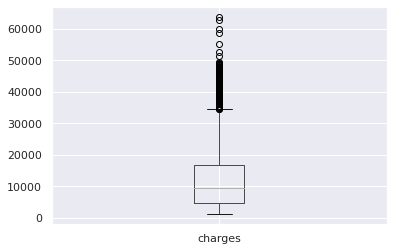

In [ ]:
# The information about charges column
df[['charges']].boxplot()

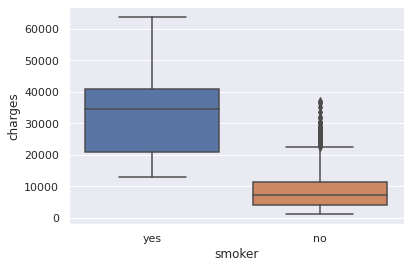

In [ ]:
# The relation between "smoker" and "charges" 
sns.boxplot(x='smoker',y='charges',data=df)

In [ ]:
le = LabelEncoder()
df["region"] = le.fit_transform(df["region"])
df["smoker"] = le.fit_transform(df["smoker"])
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,3,16884.924
1,18,male,33.770,1,0,2,1725.552
2,28,male,33.000,3,0,2,4449.462
3,33,male,22.705,0,0,1,21984.471
4,32,male,28.880,0,0,1,3866.855


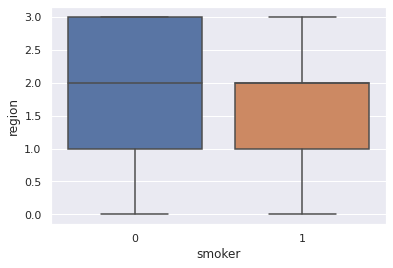

In [ ]:
# The relation between "smoker" and "region" 
sns.boxplot(x='smoker',y='region',data=df)

---

## Mert

### Q.3. region with most children

In [ ]:
df = pd.read_csv('./insurance.csv')
# region with most children

# input: pandas dataframe
# return: region with most children

def region_most_children(df: 'pd.DataFrame', output:'str'='')-> 'str':
    # dictionary keys: region names, values: None
    reg_child_dict = dict.fromkeys(df.region.unique())

    # below for loop assigns values to reg_child_dict dictionary
    for key in reg_child_dict:
        reg_child_dict[key] = df[df["region"] == key].children.sum()
    return max(reg_child_dict, key=reg_child_dict.get)
region_most_children(df)

'southeast'

### Q.3. relation between "children" and "bmi"

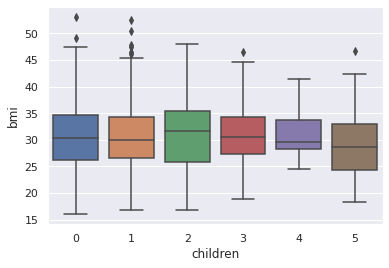

In [ ]:
#   below boxplot shows the relation between "children" and "bmi" 
sns.boxplot(x='children',y='bmi',data=df)

# Merve 



- Bmi (Vücut Kitle İndeksi)’nin dağılımını inceleyiniz
- “bmi” değişkeninde outlier var mıdır? İnceleyiniz.




In [ ]:
df = pd.read_csv('./insurance.csv')
##Analysing the data stats

unique_val = df['sex'].value_counts()
print(unique_val)

df.describe()

male      676
female    662
Name: sex, dtype: int64


,age,bmi,children,charges
count,1338.000,1338.000,1338.000,1338.000
mean,39.207,30.663,1.095,13270.422
std,14.050,6.098,1.205,12110.011
min,18.000,15.960,0.000,1121.874
25%,27.000,26.296,0.000,4740.287
50%,39.000,30.400,1.000,9382.033
75%,51.000,34.694,2.000,16639.913
max,64.000,53.130,5.000,63770.428


In [ ]:
#The factors that might affect the health insurance cost are:-

#Age: Age of the beneficiary
#Sex: Gender of the beneficiary
#BMI: Body Mass Index (kg / m^2)
#Children: Number of children / Number of dependants
#Smoker: Does smoke or not
#Region: Residential area of the beneficiary '''

# null data check

df.isnull().values.any()

False

In [ ]:
# The datatype of the all the categories are correct, hence no changes needed. Also, there are no null valued elements

# This shows a brief description of the "bmi" column.

df['bmi'].describe()

count   1338.000
mean      30.663
std        6.098
min       15.960
25%       26.296
50%       30.400
75%       34.694
max       53.130
Name: bmi, dtype: float64

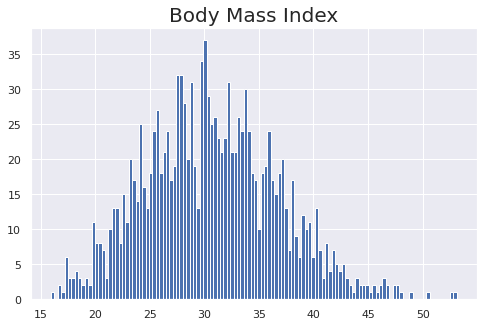

In [ ]:
'''Few observations:-

The minimum of an bmi is 15.96
Around 75% of the bmi are below 35.00
The maximum of an bmi is 53.13 
'''

# Histrogram of Body Mass Index (kg / m^2)

plt.figure(figsize=(8,5))
df.bmi.hist(bins=120)
plt.title('Body Mass Index', fontsize=20)
plt.show()

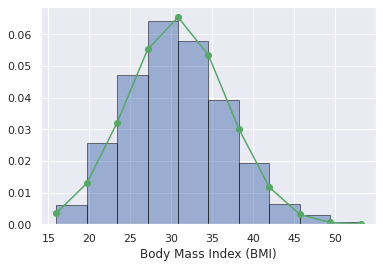

In [ ]:
"""Günümüzde BMI, en sık kullanılan sağlık ölçülerinden birisidir. 
Hemşireler sizin boyunuzu ve kilonuzu ölçtüğünde, kolaylıkla BMI değerinizi görürler. 
Özellikle ABD gibi ülkelerde sigorta şirketleri, müşterilerinden her yıl ne kadar para talep edeceklerini belirlerken bunu ölçüt olarak kullanırlar.

18.5'un altındaysanız aşırı zayıfsınız, (Underweight)
18.5-24.9 arasıysanız normalsiniz, (normal weight)
25-29.9 arasındaysanız kilolusunuz, ( overweight)
30'dan fazlaysanız obezsiniz demektir. (obese) 

"""

import matplotlib.pyplot as plt
from scipy import stats


_, bins, _ = plt.hist(df.bmi, bins = 10,
                      density = 1, alpha = 0.5,
                      ec= 'black' )
mu, sigma = stats.norm.fit(df.bmi)
best_fit_line = stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line, 'g-o')
plt.xlabel("Body Mass Index (BMI)")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


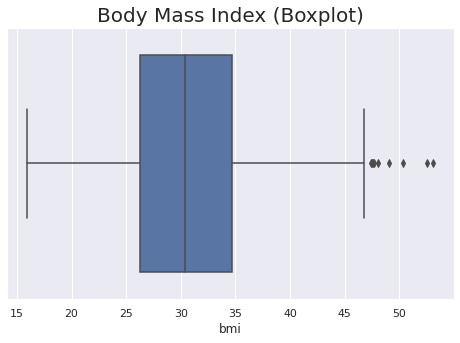

" \n45'ten sonraki çizgide noktalar bulunmaktadır, \nbunlar diğer gözlem kutusuna dahil edilmediğinden yani çeyreklerin yakınında hiçbir yerde bulunmadığından aykırı değerlerdir. \n\nGrafiğe bakıldığında bireylerin çoğunun vücut kitle endeksinin 25 ile 35 arasında olduğunu \nfakat sağdaki gözlemlerin popülasyondan uzakta olan aykırı değerler oldğu görülmektedir.\n\n"

In [ ]:
"""Yukarıdaki histogramda görüldüğü üzere bins = 10 için 10 ayrı parçaya bölerek frekans yoğunluğunu göstermiştir. 
Ayrıca çağ eğrisi çizdirerek histogramın dağılımını gözlemlemek daha kolay bir hale gelmiştir.

Bmi (vücut kitle indeksi) normal dağılım göstermiştir. 

Ortalama vücut kitle indeksi 30.7'de yığılmıştır bu da datada yer alan kişilerin obeziteye yakın olduğunu gösterir."""

# Boxplot of Body Mass Index:
plt.figure(figsize=(8,5))
sns.boxplot(df['bmi'])
plt.title('Body Mass Index (Boxplot)', fontsize=20)
plt.show()


""" 
45'ten sonraki çizgide noktalar bulunmaktadır, 
bunlar diğer gözlem kutusuna dahil edilmediğinden yani çeyreklerin yakınında hiçbir yerde bulunmadığından aykırı değerlerdir. 

Grafiğe bakıldığında bireylerin çoğunun vücut kitle endeksinin 25 ile 35 arasında olduğunu 
fakat sağdaki gözlemlerin popülasyondan uzakta olan aykırı değerler oldğu görülmektedir.

"""

# Turhan

In [ ]:
df = pd.read_csv('./insurance.csv')
data = df.copy()
print('Veri Setinin Satır Sayısı {0}, Sütün Sayısı {1}'.format(data.shape[0],data.shape[1]))

Veri Setinin Satır Sayısı 1338, Sütün Sayısı 7


In [ ]:
print('Veri Setinin Betimsel istatistik Sonuçları:\n------------------------------------------------\n', data.describe().T)

Veri Setinin Betimsel istatistik Sonuçları:
------------------------------------------------
             count      mean       std      min      25%      50%       75%       max
age      1338.000    39.207    14.050   18.000   27.000   39.000    51.000    64.000
bmi      1338.000    30.663     6.098   15.960   26.296   30.400    34.694    53.130
children 1338.000     1.095     1.205    0.000    0.000    1.000     2.000     5.000
charges  1338.000 13270.422 12110.011 1121.874 4740.287 9382.033 16639.913 63770.428


In [ ]:
print('Öznitelikler Hakkında Özet Bilgiler:\n------------------------------------------------')
print(data.info())

Öznitelikler Hakkında Özet Bilgiler:
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [ ]:
print('Özniteliklerin Kayıp Değer Sayıları:\n-------------------')
print(data.isnull().sum())

Özniteliklerin Kayıp Değer Sayıları:
-------------------
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Harika, hiç eksik değerimiz yok. Şimdi bazı grafiklerle EDA yapalım :)

## Ücret Dağılımı

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


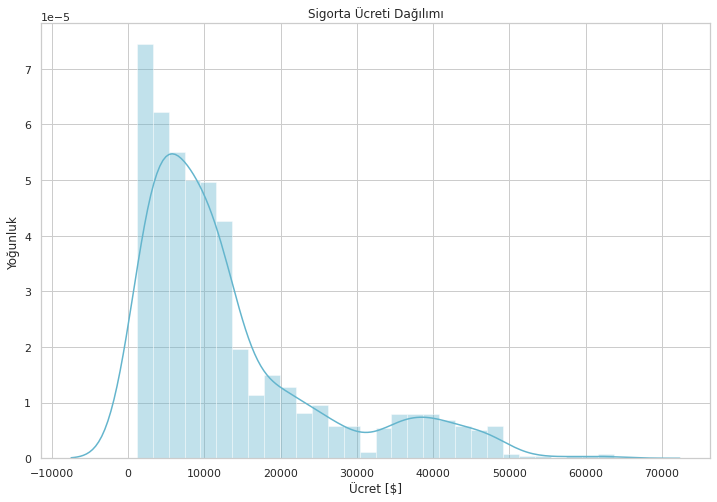

In [ ]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(data['charges'], kde = True, color = 'c')
ax.set_xlabel('Ücret [$]')
ax.set_ylabel('Yoğunluk')
plt.title('Sigorta Ücreti Dağılımı')
plt.show()

## Korelasyon Matrisi

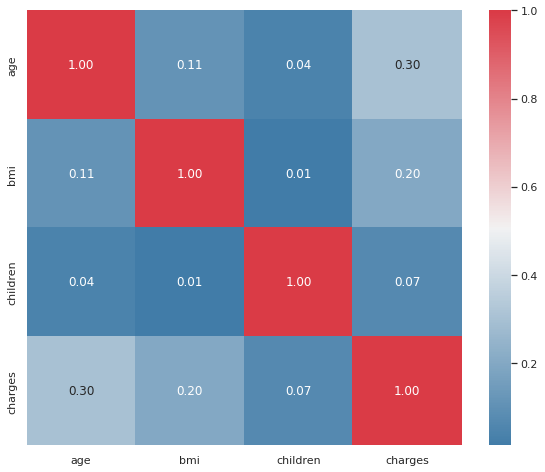

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax,annot = True, fmt='.2f')
plt.show()

## BMI vs Cinsiyet
Cinsiyet kategorik bir veri olduğu için korelasyon matrisinde göremedik. Bu sebeple cinsiyete bir operasyon uygulamamız gereklidir. 

LabelEncoder uygulayarak cinsiyeti sayısal hale getirebiliriz.*italik metin*

In [ ]:
le = LabelEncoder() 
le.fit(data.sex.drop_duplicates()) # sadece female ve male olarak fit ediyorum
data.sex = le.transform(data.sex) # veri setine uyguluyoruz
data.sex 

0       0
1       1
2       1
3       1
4       1
       ..
1333    1
1334    0
1335    0
1336    0
1337    0
Name: sex, Length: 1338, dtype: int64

Artık Kadın -> 0 ve Erkek -> 1 olarak ifade ediliyor

In [ ]:
data.sex.value_counts() # Kaç kadın, kaç erkek var bakalım

1    676
0    662
Name: sex, dtype: int64

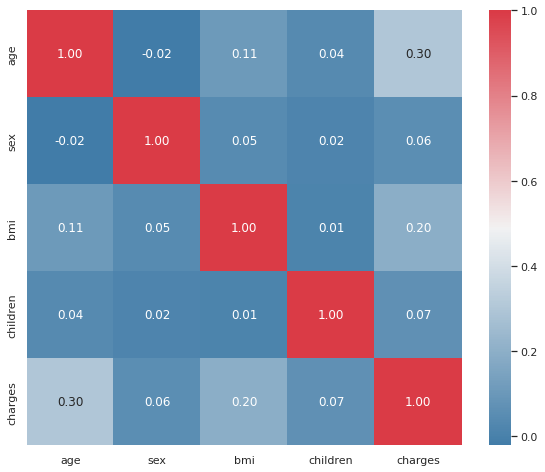

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax,annot = True, fmt='.2f')
plt.show()

Görüldüğü gibi şimdi korelasyon matrisinde cinsiyet değerini görebiliyoruz. 
* Cinsiyet ve BMI arasında 0.05'lik az bir pozitif korelasyon var.
* Şimdi bu değişkenleri kendi aralarında görselleştirelim

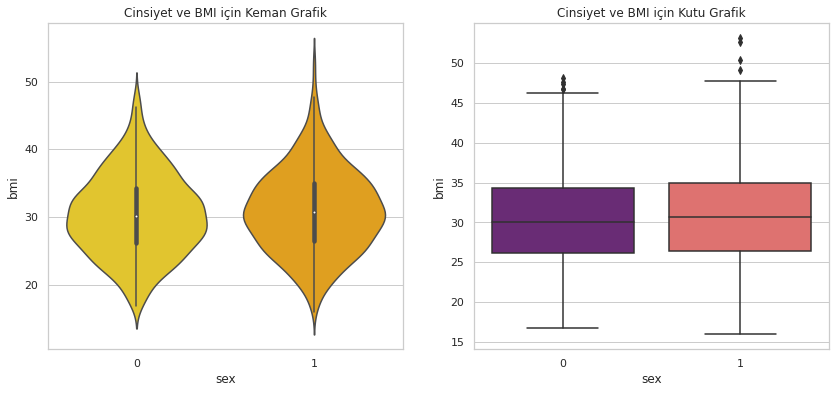

In [ ]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='sex', y='bmi',data=data,palette='Wistia',ax=ax)
ax.set_title('Cinsiyet ve BMI için Keman Grafik')

ax = f.add_subplot(122)
sns.boxplot(x='sex', y='bmi',data=data,palette='magma',ax=ax)
ax.set_title('Cinsiyet ve BMI için Kutu Grafik');

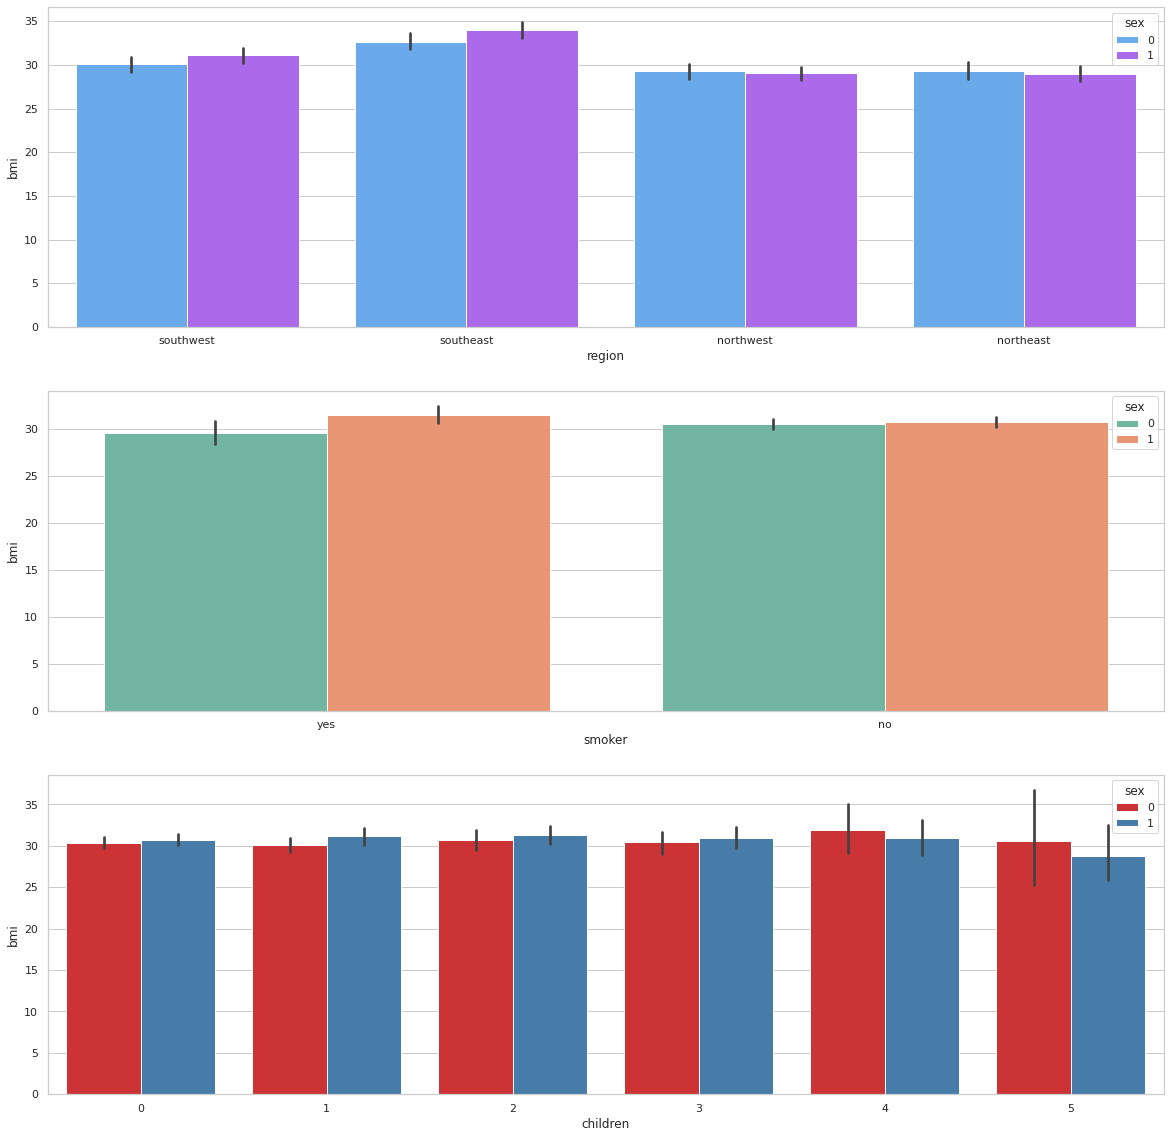

In [ ]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(311)
ax = sns.barplot(x='region', y='bmi', hue='sex',data=data, palette='cool')

ax = f.add_subplot(312)
ax = sns.barplot(x='smoker', y='bmi', hue='sex',data=data, palette='Set2')

ax = f.add_subplot(313)
ax = sns.barplot(x='children', y='bmi', hue='sex',data=data, palette='Set1')

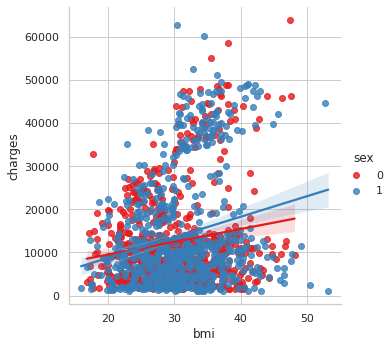

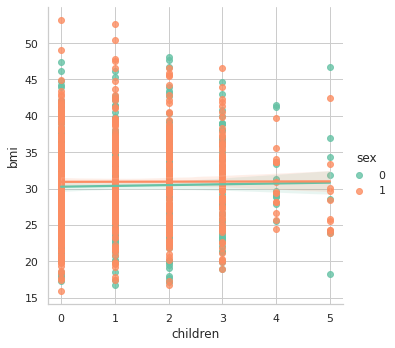

In [ ]:
ax = sns.lmplot(x = 'bmi', y = 'charges', data=data, hue='sex', palette='Set1')
ax = sns.lmplot(x = 'children', y = 'bmi', data=data, hue='sex', palette='Set2')

## BMI vs Maliyet
Bu iki değişken de nümerik olduğu için herhangi bir oerasyon uygulamaya gerek yok. 

Yurakıdaki korelasyon matrisine bakılırsa Maliyet ve BMI arasında 0.20'lik nisbeten yüksek bir pozitif korelasyon var.
* Şimdi bu değişkenleri kendi aralarında görselleştirelim

Text(0.5, 1.0, 'Charge Vs BMI')

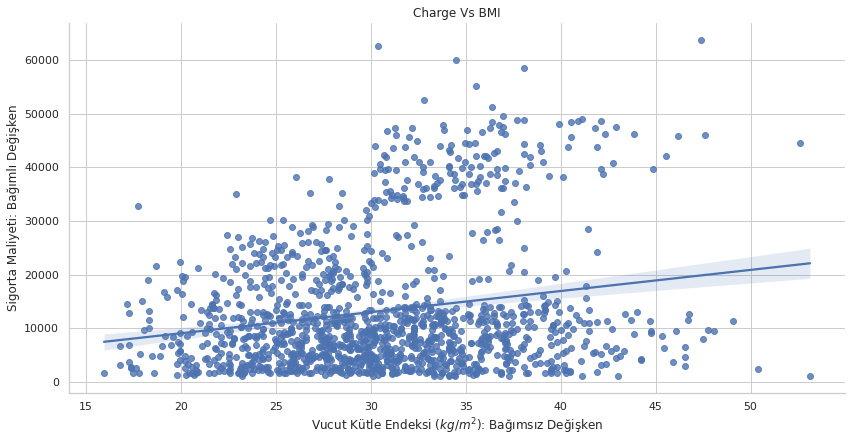

In [ ]:
sns.lmplot(x='bmi',y='charges',data=data,aspect=2,height=6)
plt.xlabel('Vucut Kütle Endeksi $(kg/m^2)$: Bağımsız Değişken')
plt.ylabel('Sigorta Maliyeti: Bağımlı Değişken')
plt.title('Charge Vs BMI')

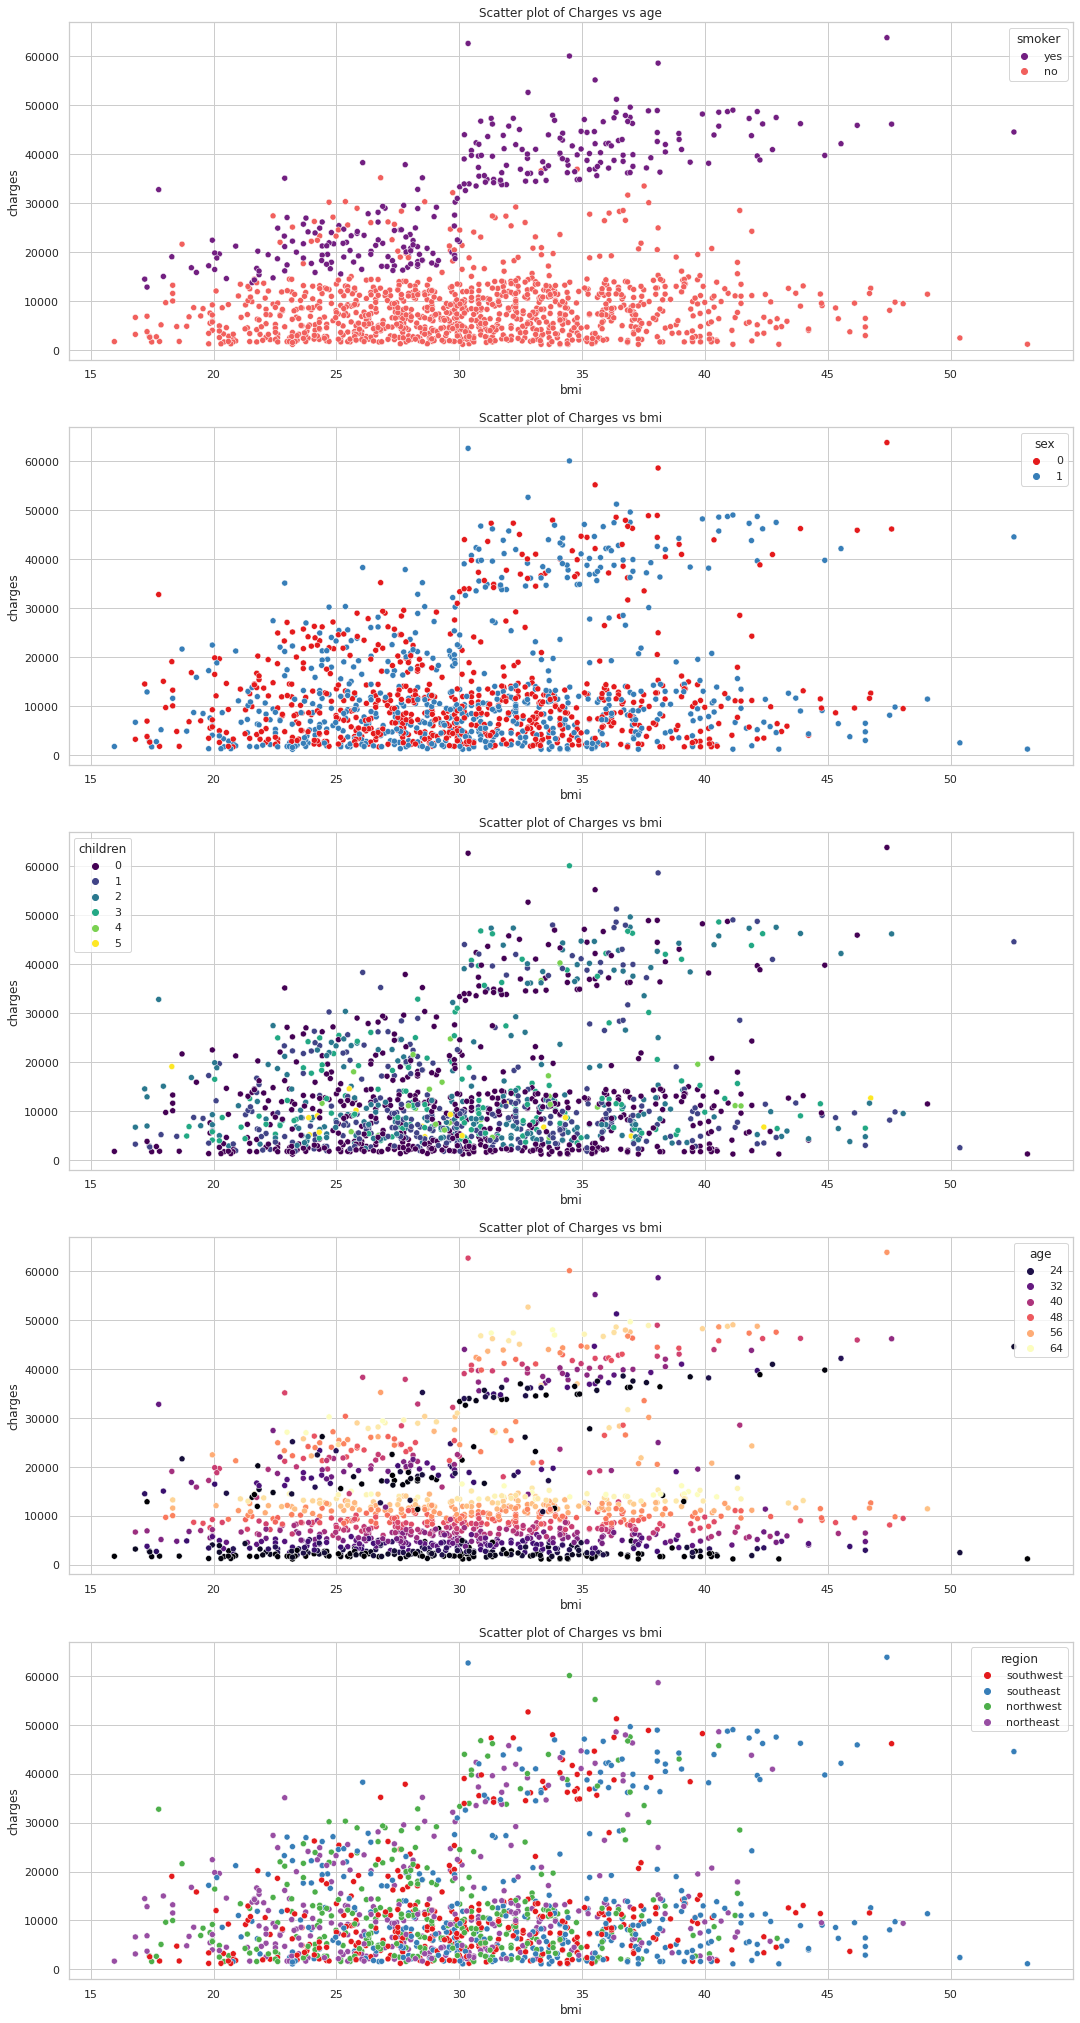

In [ ]:
f = plt.figure(figsize=(18,36))
ax = f.add_subplot(511)
sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(512)
sns.scatterplot(x='bmi',y='charges',data=data,palette='Set1',hue='sex')
ax.set_title('Scatter plot of Charges vs bmi')

ax = f.add_subplot(513)
sns.scatterplot(x='bmi',y='charges',data=data,palette='viridis',hue='children')
ax.set_title('Scatter plot of Charges vs bmi')

ax = f.add_subplot(514)
sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='age')
ax.set_title('Scatter plot of Charges vs bmi')

ax = f.add_subplot(515)
sns.scatterplot(x='bmi',y='charges',data=data,palette='Set1',hue='region')
ax.set_title('Scatter plot of Charges vs bmi')

plt.show()

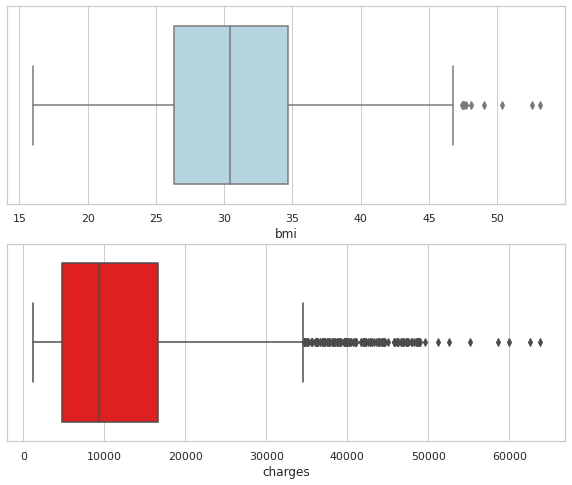

In [ ]:
# Bmi ve Sigorta Maliyeti için aykırı değerleri bulalım
plt.figure(figsize= (10,8))
plt.subplot(2,1,1)
sns.boxplot(x= data.bmi, color='lightblue')

plt.subplot(2,1,2)
sns.boxplot(x= data.charges, color='red')

plt.show()

# Q.4

In [ ]:
# ENCODING
df = pd.read_csv('./insurance.csv')
#  One-Hot Encoding
df = pd.get_dummies(df, columns=['region'], drop_first=False, dummy_na=False)
# Label Encoding
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.924,0,0,0,1
1,18,1,33.770,1,0,1725.552,0,0,1,0
2,28,1,33.000,3,0,4449.462,0,0,1,0
3,33,1,22.705,0,0,21984.471,0,1,0,0
4,32,1,28.880,0,0,3866.855,0,1,0,0


In [ ]:
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'charges'], df.charges, test_size = 0.2, random_state = 42)

# NORMALIZATION

# X_train
   # age 
X_train["age"] = (X_train["age"]-X_train["age"].mean()) / X_train["age"].std()
   # bmi
X_train["bmi"] = (X_train["bmi"]-X_train["bmi"].mean()) / X_train["bmi"].std()
  # children
X_train["children"] = (X_train["children"]-X_train["children"].mean()) / X_train["children"].std()

# X_test
   # age 
X_test["age"] = (X_test["age"]-X_test["age"].mean()) / X_test["age"].std()
   # bmi
X_test["bmi"] = (X_test["bmi"]-X_test["bmi"].mean()) / X_test["bmi"].std()
   # children
X_test["children"] = (X_test["children"]-X_test["children"].mean()) / X_test["children"].std()

In [ ]:
print('X Train Verisi:\n', X_train)

X Train Verisi:
         age  sex    bmi  children  smoker  region_northeast  region_northwest  region_southeast  region_southwest
560   0.472    0 -1.756     0.734       0                 0                 1                 0                 0
1285  0.543    0 -1.033    -0.911       0                 1                 0                 0                 0
1142  0.898    0 -0.943    -0.911       0                 0                 0                 1                 0
969  -0.025    0  0.622     3.201       0                 0                 0                 1                 0
486   1.040    0 -1.504     1.556       0                 0                 1                 0                 0
...     ...  ...    ...       ...     ...               ...               ...               ...               ...
1095 -1.517    0  0.131     2.379       0                 1                 0                 0                 0
1130 -0.025    0 -1.107     3.201       0                 0            

In [ ]:
print('X Test Verisi:\n', X_test)

X Test Verisi:
         age  sex    bmi  children  smoker  region_northeast  region_northwest  region_southeast  region_southwest
764   0.458    0 -0.935     0.821       0                 1                 0                 0                 0
887  -0.187    0 -0.167    -0.898       0                 0                 1                 0                 0
890   1.818    0 -0.664    -0.898       1                 0                 1                 0                 0
1293  0.529    1 -0.845     1.680       0                 0                 1                 0                 0
259  -1.404    1  0.134    -0.898       1                 0                 1                 0                 0
...     ...  ...    ...       ...     ...               ...               ...               ...               ...
109   1.747    1  0.637    -0.898       1                 0                 0                 1                 0
575   1.389    0 -0.619    -0.898       0                 0             

In [ ]:
print('y Train Verisi:\n', y_train)

y Train Verisi:
 560     9193.838
1285    8534.672
1142   27117.994
969     8596.828
486    12475.351
          ...   
1095    4561.189
1130    8582.302
1294   11931.125
860    46113.511
1126   10214.636
Name: charges, Length: 1070, dtype: float64


In [ ]:
print('y Test Verisi:\n', y_test)

y Test Verisi:
 764     9095.068
887     5272.176
890    29330.983
1293    9301.894
259    33750.292
          ...   
109    47055.532
575    12222.898
535     6067.127
543    63770.428
846     9872.701
Name: charges, Length: 268, dtype: float64


#  Linear Regression

Tıbbi maliyet veri seti için bir Lineer regresyon modeli oluşturacağız. Veri seti; yaş, cinsiyet, BMI(vücut kitle indeksi), çocuk, sigara içen ve bölge özelliklerinden bağımsız ve bağımlı özellik olarak ücretten oluşmaktadır. Sağlık sigortası tarafından faturalanan bireysel tıbbi masrafları tahmin edeceğiz.

Doğrusal regresyon, hedef/bağımlı değişken sürekli olduğu durumlarda kullanılan denetimli bir öğrenme algoritmasıdır. En uygun çizgiyi kullanarak bağımlı değişken 𝑦 ile bir veya daha fazla bağımsız değişken 𝑥 arasında ilişki kurar. Sıradan en küçük kare (OLS) / Ortalama kare hatası (MSE) prensibi ile çalışır. İstatistikte OLS, lineer regresyon fonksiyonunun bilinmeyen parametresini tahmin etme yöntemidir, amacı, verilen veri setinde gözlemlenen bağımlı değişken ile lineer regresyon fonksiyonu tarafından tahmin edilenler arasındaki kare farkının toplamını en aza indirmektir. Doğrusal regresyon kullanarak model oluşturalım.

In [ ]:
linear_model = sklearn.linear_model.LinearRegression()
ridge_model = sklearn.linear_model.Ridge() #L2
lasso_model = sklearn.linear_model.Lasso() #L1

linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

print("Coefficient of the Linear Model:",linear_model.coef_)
print("Intercept of the Linear Model:", linear_model.intercept_)
print('--------------------------------------------------------')
print("Coefficient of the Ridge Model:",ridge_model.coef_)
print("Intercept of the Ridge Model:", ridge_model.intercept_)
print('--------------------------------------------------------')
print("Coefficient of the Lasso Model:",lasso_model.coef_)
print("Intercept of the Lasso Model:", lasso_model.intercept_)

Coefficient of the Linear Model: [ 3.61666584e+03 -1.85916916e+01  2.03718030e+03  5.17131954e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]
Intercept of the Linear Model: 8495.659557259154
--------------------------------------------------------
Coefficient of the Ridge Model: [ 3.61075831e+03 -1.06810959e+01  2.03475842e+03  5.17821221e+02
  2.35145639e+04  4.58215681e+02  8.51974952e+01 -1.91793787e+02
 -3.51619389e+02]
Intercept of the Ridge Model: 8519.54786041561
--------------------------------------------------------
Coefficient of the Lasso Model: [ 3.61577984e+03 -1.39722493e+01  2.03529387e+03  5.16279252e+02
  2.36443193e+04  6.49104074e+02  2.78101347e+02 -0.00000000e+00
 -1.52396949e+02]
Intercept of the Lasso Model: 8300.8884437317


In [ ]:
lin_pred = linear_model.predict(X_test)
ridge_pred = ridge_model.predict(X_test)
lasso_pred = lasso_model.predict(X_test)

In [ ]:
print (f'Linear MSE: {metrics.mean_squared_error(y_test , lin_pred)}')
print (f'Linear MAE: {metrics.mean_absolute_error(y_test , lin_pred)}')
print (f'Linear r2_score: {metrics.r2_score(y_test , lin_pred)}')
print (f'Linear RMSE: {np.sqrt(metrics.mean_squared_error(y_test , lin_pred))}')

Linear MSE: 33585722.78385136
Linear MAE: 4167.042397319182
Linear r2_score: 0.7836650743543689
Linear RMSE: 5795.319040730317


In [ ]:
print (f'Ridge MSE: {metrics.mean_squared_error(y_test , ridge_pred)}')
print (f'Ridge MAE: {metrics.mean_absolute_error(y_test , ridge_pred)}')
print (f'Ridge r2_score: {metrics.r2_score(y_test , ridge_pred)}')
print (f'Ridge RMSE: {np.sqrt(metrics.mean_squared_error(y_test , ridge_pred))}')

Ridge MSE: 33632032.490910955
Ridge MAE: 4179.259197912274
Ridge r2_score: 0.783366780728298
Ridge RMSE: 5799.31310509365


In [ ]:
print (f'Lasso MSE: {metrics.mean_squared_error(y_test , lasso_pred)}')
print (f'Lasso MAE: {metrics.mean_absolute_error(y_test , lasso_pred)}')
print (f'Lasso r2_score: {metrics.r2_score(y_test , lasso_pred)}')
print (f'Lasso RMSE: {np.sqrt(metrics.mean_squared_error(y_test , lasso_pred))}')

Lasso MSE: 33594710.1634408
Lasso MAE: 4167.958834958175
Lasso r2_score: 0.7836071841577594
Lasso RMSE: 5796.0943887622125


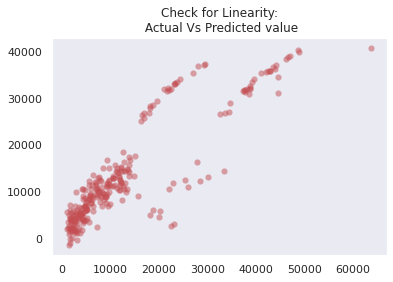

In [ ]:
# Lineer Model En iyi Sonucu Verdi
plt.scatter(y_test,lin_pred,color='r',linewidths=0.1,alpha=0.5)
plt.title('Lineerlik Kontrolü:\n Actual Vs Predicted value')
plt.show()

In [ ]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':lin_pred,'Difference':abs(y_test-lin_pred)})
pred_df

,Actual Value,Predicted Value,Difference
764,9095.068,9129.705,34.637
887,5272.176,7104.036,1831.860
890,29330.983,36994.632,7663.649
1293,9301.894,9628.001,326.108
259,33750.292,26947.230,6803.062
...,...,...,...
109,47055.532,39080.070,7975.462
575,12222.898,11881.543,341.356
535,6067.127,7774.194,1707.067
543,63770.428,40747.003,23023.425


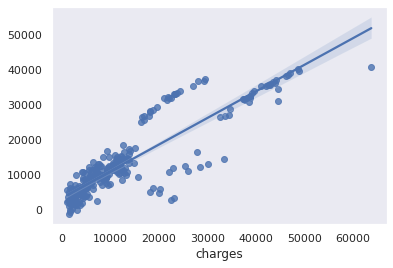

In [ ]:
sns.regplot(x=y_test,y=lin_pred)
plt.show()

# Polynomial Regression

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [ ]:
le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])
df["smoker"] = le.fit_transform(df["smoker"])
df.head()

In [ ]:
df['region']=df['region'].astype('category')
enc = OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(df[['region']]).toarray())
df = df.join(enc_data)
df.head()

In [ ]:
df = df.drop(df[['region']], axis= 1)
df.head()

In [ ]:
y = df['charges']
X = df.drop(df[['charges']], axis =1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)
X_poly_test = poly_reg.fit_transform(X_test)
model = LinearRegression()
model.fit(X_poly, y_train)
y_poly_pred = model.predict(X_poly_test)
mse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print(mse)
print(r2)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from numpy import mean
from numpy import std

# Model
model = RandomForestRegressor()

parameters = {
    "n_estimators":[5,10,50,100,250,500,1000],
    "max_depth":[2,4,8,16,32,None]
}

# Grid Search for Hyperparameters
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(model,parameters,cv=5)
cv.fit(X_train,y_train.ravel())

# Grid Search Results Displayer
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

# Display Grid Search Results
display(cv)


# Train Model
model = RandomForestRegressor(max_depth=cv.best_params_["max_depth"],n_estimators=cv.best_params_["n_estimators"])
model.fit(X_train, y_train)


# Evaluate the model

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# Report training performance
print("------")
print("\n")
print("Training error")
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("------")

# Report on test
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print("Test error")
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
#######################################
# Base Models
#######################################

# !pip install xgboost
# !pip install lightgbm
# conda install -c conda-forge lightgbm
# !pip install catboost

import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

from helpers.data_preparation import *
from helpers.exploratory_data_analysis import *


models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ("LightGBM", LGBMRegressor()),
          ]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


######################################################
# Automated Hyperparameter Optimization
######################################################


rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500, 1000]}

lightgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

regressors = [("RF", RandomForestRegressor(), rf_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


